In [1]:
#out_file = 'U19-depth.h5'
#model = 'U19_2019-09-18/first_model.p'
#index = 'U19_2019-09-18/moseq2-index.timepoint.yaml'
#tag_file = 'u19-tags.csv'
out_dir = '/home/mhaas/Projects/moseq2_tags/keras_dset'
model = '/home/mhaas/Projects/moseq2_tags/raw_tag_data/PNKD_CT_2019-09-14/CT-first.p'
index = '/home/mhaas/Projects/moseq2_tags/raw_tag_data/PNKD_CT_2019-09-14/gender-genotype-index.yaml'
tag_file = '/home/mhaas/Projects/moseq2_tags/raw_tag_data/pnkd_ct-tags.csv'

In [2]:
from syl_slices import get_syl_slices

slices = get_syl_slices(model,index)

Setting CPU affinity to use all CPUs...


100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


In [3]:
import pandas as pd

tags = pd.read_csv(tag_file)
tags.set_index('Syllable', inplace=True)
tags.Tag

Syllable
0     micro
1     micro
2     micro
3     pause
4      dart
      ...  
87     rear
90     dart
91     rear
93     rear
96     rear
Name: Tag, Length: 92, dtype: object

In [4]:
tag_groups = tags.Tag.unique()
tag_groups.sort()
list(tag_groups)
tag_groups

array(['dart', 'micro', 'pause', 'rear', 'walk'], dtype=object)

In [5]:
for i in range(len(tag_groups)):
    tags.Tag = tags.Tag.replace(tag_groups[i],i)

In [6]:
tags.Tag[:10]

Syllable
0    1
1    1
2    1
3    2
4    0
5    0
6    2
7    2
8    4
9    2
Name: Tag, dtype: int64

In [7]:
from tqdm import tqdm

slices_flat = []

for i in tqdm(range(len(slices))):
    for inst in slices[i]:
        slices_flat.append(inst)
        slices_flat[-1].append(tags.loc[i].values[0])

100%|██████████| 100/100 [01:05<00:00,  1.54it/s]


In [8]:
print(len(slices_flat))
print(slices_flat[0])
print(slices_flat[-1])

321628
[(76, 81), '01d76f5e-cc1e-41ed-a0e1-024b5bd448e0', '/home/mhaas/Projects/moseq2_tags/raw_tag_data/PNKD_CT_2019-09-14/_aggregate_results/2018-08-14_t12-29-34_2018-08-14__pnkd_ct-f_cohort0606_cage-ww_mouse-4_results_00.h5', 1]
[(35691, 35739), 'c6a779e0-3bcf-4ade-8d7b-da3d24a32f89', '/home/mhaas/Projects/moseq2_tags/raw_tag_data/PNKD_CT_2019-09-14/_aggregate_results/2018-08-13_t14-43-42_2018-08-13__pnkd_ct_cohort0606_cage-yy_mouse-13_results_00.h5', 3]


In [9]:
import numpy as np

max_len = 30
#insts = np.full((len(slices_flat),max_len,80,80),-10,dtype=np.int8)

In [10]:
slices_df = pd.DataFrame(slices_flat,columns=['Frames','UUID','Path','Tag'])

In [13]:
import os
import h5py
import random
#from progressbar import ProgressBar

#pbar = ProgressBar()

np_indices = list(range(len(slices_flat)))
seed = -10
if seed != -1:
    random.seed(seed)
random.shuffle(np_indices)
tags_np = np.zeros((len(slices_flat)),dtype=int)
num_digits = len(str(abs(len(np_indices))))
i = 0
for h_file in tqdm(slices_df.Path.unique()):
    with h5py.File(h_file,'r') as f:
        frames = np.array(f['frames'])
    for _, row in slices_df.loc[slices_df['Path'] == h_file].iterrows():
        inst_np = np.full((1,max_len,80,80),-10,dtype=np.int8)
        inst_len = row['Frames'][1]-row['Frames'][0]
        if inst_len < max_len:
            inst_np[0,:inst_len] = frames[row['Frames'][0]:row['Frames'][1]]
        else:
            inst_np[0] = frames[row['Frames'][0]:row['Frames'][0]+max_len]
            
        index = np_indices[i]
        np.savez_compressed(os.path.join(out_dir,'inst_{number:0{digits:}}.npz'.format(number=index,digits=num_digits)), inst_np)
        #tag_list.append(row['Tag'])
        tags_np[index] = row['Tag']
        i+=1

100%|██████████| 143/143 [23:37<00:00,  9.91s/it]


In [15]:
labels_df = pd.DataFrame({'Label':tags_np})
labels_df.to_csv(os.path.join(out_dir,'labels.csv'))

In [16]:
np_list = []
for filename in sorted(os.listdir(out_dir)):
    if filename.endswith('.npz'):
        np_list.append(os.path.join(out_dir,filename))

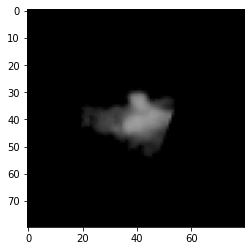

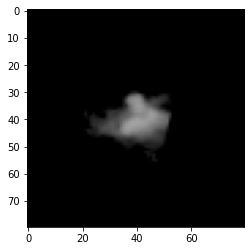

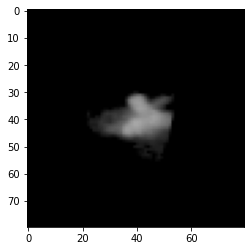

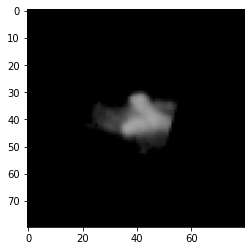

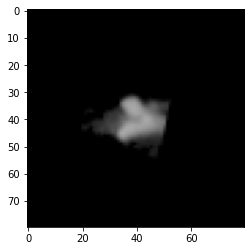

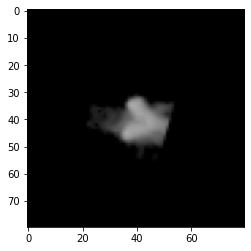

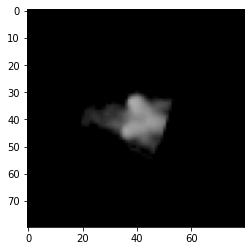

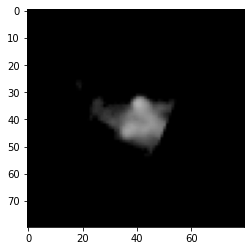

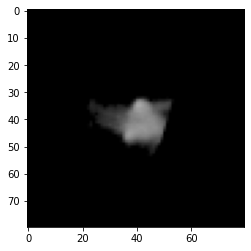

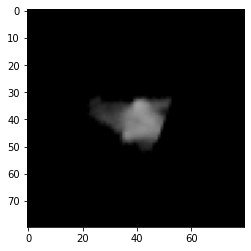

In [33]:
import matplotlib.pyplot as plt

inst_index = 4
inst_np = np.load(np_list[inst_index])['arr_0'][0]
for frame in inst_np:
    if frame[0][0] == -10:
        break
    plt.imshow(frame,cmap=plt.get_cmap('gray'),vmin=0,vmax=100)
    plt.show()